In [1]:
%load_ext autoreload 
%autoreload 2

# Exp6 Pretrain Patch GAN to obtain feature extractor (fundus)

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2, Discriminator_128_v2_PatchGAN
from loader import All_fundus_files

In [2]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 100
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# dataloader
'''
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''
train_dataset = All_fundus_files(transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2_PatchGAN(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [20,60,90], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [20,60,90], gamma=0.1)

41317
41317
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [4]:
from torchsummary import summary
summary(net_D, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 7, 7]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 7, 7]               0
        LeakyReLU-14           [-1, 102

In [5]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp6/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [6]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/100] Iter:1  Loss_D=0.3128 Loss_G=21.7472 D(x)=0.6717 D(G(z))=0.5276, -3.7220
[0/100] Iter:51  Loss_D=1.4095 Loss_G=10.5646 D(x)=1.5586 D(G(z))=1.0767, -2.2788
[0/100] Iter:101  Loss_D=0.1653 Loss_G=0.6470 D(x)=0.7030 D(G(z))=0.0459, 0.1343
[0/100] Iter:151  Loss_D=0.1001 Loss_G=1.6351 D(x)=0.9905 D(G(z))=0.3363, -0.3213
[0/100] Iter:201  Loss_D=0.2518 Loss_G=2.7084 D(x)=0.9850 D(G(z))=0.5899, -0.6767
[0/100] Iter:251  Loss_D=0.1608 Loss_G=1.1448 D(x)=0.9817 D(G(z))=0.4319, -0.1040
[0/100] Iter:301  Loss_D=2.4097 Loss_G=0.4877 D(x)=0.3586 D(G(z))=-1.1831, 1.6406
[1/100] Iter:1  Loss_D=0.1354 Loss_G=0.5555 D(x)=0.8966 D(G(z))=0.3557, 0.2212
[1/100] Iter:51  Loss_D=0.1304 Loss_G=0.6266 D(x)=0.8086 D(G(z))=0.0390, 0.1821
[1/100] Iter:101  Loss_D=0.3594 Loss_G=1.7306 D(x)=1.0737 D(G(z))=0.6645, -0.3562
[1/100] Iter:151  Loss_D=0.1173 Loss_G=0.6440 D(x)=0.8212 D(G(z))=0.0208, 0.1700
[1/100] Iter:201  Loss_D=2.7123 Loss_G=0.3624 D(x)=-0.0037 D(G(z))=-1.1696, 1.5475
[1/100] Iter:251  Loss_

[14/100] Iter:201  Loss_D=0.2797 Loss_G=0.8451 D(x)=1.0114 D(G(z))=0.6145, 0.0386
[14/100] Iter:251  Loss_D=0.1401 Loss_G=0.4781 D(x)=0.6950 D(G(z))=0.3325, 0.2854
[14/100] Iter:301  Loss_D=0.2685 Loss_G=0.2810 D(x)=0.5269 D(G(z))=0.3364, 0.4316
[15/100] Iter:1  Loss_D=0.6342 Loss_G=0.0565 D(x)=0.2704 D(G(z))=-0.0893, 0.7605
[15/100] Iter:51  Loss_D=0.2509 Loss_G=0.6432 D(x)=0.8955 D(G(z))=0.5660, 0.1505
[15/100] Iter:101  Loss_D=0.1621 Loss_G=0.4720 D(x)=0.7363 D(G(z))=0.3975, 0.3009
[15/100] Iter:151  Loss_D=0.1536 Loss_G=0.3574 D(x)=0.7191 D(G(z))=0.3526, 0.3780
[15/100] Iter:201  Loss_D=0.1903 Loss_G=0.1886 D(x)=0.5768 D(G(z))=0.1606, 0.5530
[15/100] Iter:251  Loss_D=0.1776 Loss_G=0.6291 D(x)=0.8126 D(G(z))=0.4786, 0.1952
[15/100] Iter:301  Loss_D=0.2497 Loss_G=0.4346 D(x)=0.7401 D(G(z))=0.5287, 0.3042
[16/100] Iter:1  Loss_D=0.4849 Loss_G=1.0706 D(x)=0.8763 D(G(z))=0.7829, -0.0609
[16/100] Iter:51  Loss_D=0.2768 Loss_G=0.3980 D(x)=0.6751 D(G(z))=0.5417, 0.3473
[16/100] Iter:101  L

[29/100] Iter:1  Loss_D=0.1094 Loss_G=0.4679 D(x)=0.8320 D(G(z))=0.3388, 0.2712
[29/100] Iter:51  Loss_D=0.1298 Loss_G=0.4844 D(x)=0.8408 D(G(z))=0.3915, 0.2794
[29/100] Iter:101  Loss_D=0.1422 Loss_G=0.4105 D(x)=0.7593 D(G(z))=0.3590, 0.3242
[29/100] Iter:151  Loss_D=0.1158 Loss_G=0.4945 D(x)=0.8289 D(G(z))=0.3420, 0.2686
[29/100] Iter:201  Loss_D=0.1154 Loss_G=0.4850 D(x)=0.7868 D(G(z))=0.3046, 0.2786
[29/100] Iter:251  Loss_D=0.7784 Loss_G=0.3196 D(x)=0.7777 D(G(z))=0.3803, 0.3863
[29/100] Iter:301  Loss_D=0.1137 Loss_G=0.4824 D(x)=0.7938 D(G(z))=0.2909, 0.2745
[30/100] Iter:1  Loss_D=0.1212 Loss_G=0.4569 D(x)=0.7648 D(G(z))=0.3371, 0.3006
[30/100] Iter:51  Loss_D=0.8909 Loss_G=0.3368 D(x)=0.7964 D(G(z))=0.3410, 0.4342
[30/100] Iter:101  Loss_D=0.1189 Loss_G=0.4850 D(x)=0.7793 D(G(z))=0.3263, 0.2779
[30/100] Iter:151  Loss_D=0.1293 Loss_G=0.4593 D(x)=0.7602 D(G(z))=0.3205, 0.3125
[30/100] Iter:201  Loss_D=0.1189 Loss_G=0.5278 D(x)=0.7877 D(G(z))=0.2761, 0.2516
[30/100] Iter:251  Los

[43/100] Iter:151  Loss_D=0.1027 Loss_G=0.5012 D(x)=0.8624 D(G(z))=0.3025, 0.2391
[43/100] Iter:201  Loss_D=0.1222 Loss_G=0.4199 D(x)=0.7269 D(G(z))=0.2477, 0.3309
[43/100] Iter:251  Loss_D=0.1036 Loss_G=0.4805 D(x)=0.8173 D(G(z))=0.2769, 0.2959
[43/100] Iter:301  Loss_D=0.1396 Loss_G=0.4930 D(x)=0.7833 D(G(z))=0.3509, 0.2966
[44/100] Iter:1  Loss_D=0.0906 Loss_G=0.5317 D(x)=0.8445 D(G(z))=0.2749, 0.2436
[44/100] Iter:51  Loss_D=0.9390 Loss_G=0.4108 D(x)=0.7893 D(G(z))=0.2530, 0.3403
[44/100] Iter:101  Loss_D=0.1063 Loss_G=0.5434 D(x)=0.8575 D(G(z))=0.3081, 0.2366
[44/100] Iter:151  Loss_D=0.1009 Loss_G=0.5593 D(x)=0.8971 D(G(z))=0.3313, 0.2367
[44/100] Iter:201  Loss_D=0.1256 Loss_G=0.4399 D(x)=0.8268 D(G(z))=0.3524, 0.2780
[44/100] Iter:251  Loss_D=0.9800 Loss_G=0.3528 D(x)=0.7899 D(G(z))=0.2279, 0.3802
[44/100] Iter:301  Loss_D=0.1019 Loss_G=0.4680 D(x)=0.8091 D(G(z))=0.2761, 0.2915
[45/100] Iter:1  Loss_D=0.1428 Loss_G=0.4551 D(x)=0.7873 D(G(z))=0.3751, 0.2970
[45/100] Iter:51  Los

[57/100] Iter:301  Loss_D=0.0808 Loss_G=0.6481 D(x)=0.8415 D(G(z))=0.2359, 0.1621
[58/100] Iter:1  Loss_D=0.0785 Loss_G=0.5976 D(x)=0.8743 D(G(z))=0.2508, 0.1780
[58/100] Iter:51  Loss_D=0.0970 Loss_G=0.4791 D(x)=0.8379 D(G(z))=0.3083, 0.2942
[58/100] Iter:101  Loss_D=0.0916 Loss_G=0.5317 D(x)=0.8832 D(G(z))=0.3425, 0.2382
[58/100] Iter:151  Loss_D=0.0817 Loss_G=0.5311 D(x)=0.8731 D(G(z))=0.2914, 0.2510
[58/100] Iter:201  Loss_D=0.1078 Loss_G=0.6518 D(x)=0.9101 D(G(z))=0.3489, 0.1693
[58/100] Iter:251  Loss_D=0.8963 Loss_G=0.2801 D(x)=0.7894 D(G(z))=0.3068, 0.4467
[58/100] Iter:301  Loss_D=0.0833 Loss_G=0.4786 D(x)=0.7958 D(G(z))=0.2174, 0.2730
[59/100] Iter:1  Loss_D=1.0555 Loss_G=0.3183 D(x)=0.8258 D(G(z))=0.2395, 0.4230
[59/100] Iter:51  Loss_D=0.1165 Loss_G=0.4535 D(x)=0.7309 D(G(z))=0.2708, 0.3082
[59/100] Iter:101  Loss_D=0.0901 Loss_G=0.5030 D(x)=0.8078 D(G(z))=0.2553, 0.2882
[59/100] Iter:151  Loss_D=0.1124 Loss_G=0.4352 D(x)=0.7243 D(G(z))=0.1697, 0.3201
[59/100] Iter:201  Los

[72/100] Iter:101  Loss_D=0.0878 Loss_G=0.4773 D(x)=0.8217 D(G(z))=0.3014, 0.2937
[72/100] Iter:151  Loss_D=0.9759 Loss_G=0.4743 D(x)=0.8486 D(G(z))=0.2906, 0.2979
[72/100] Iter:201  Loss_D=0.0713 Loss_G=0.5139 D(x)=0.8503 D(G(z))=0.2562, 0.2490
[72/100] Iter:251  Loss_D=0.0774 Loss_G=0.5019 D(x)=0.8364 D(G(z))=0.2798, 0.2639
[72/100] Iter:301  Loss_D=0.0848 Loss_G=0.5136 D(x)=0.8085 D(G(z))=0.2571, 0.2522
[73/100] Iter:1  Loss_D=0.0796 Loss_G=0.4851 D(x)=0.8592 D(G(z))=0.3076, 0.2910
[73/100] Iter:51  Loss_D=0.0862 Loss_G=0.4829 D(x)=0.8202 D(G(z))=0.2618, 0.2668
[73/100] Iter:101  Loss_D=0.0908 Loss_G=0.4954 D(x)=0.8362 D(G(z))=0.2685, 0.2639
[73/100] Iter:151  Loss_D=0.0858 Loss_G=0.4958 D(x)=0.8208 D(G(z))=0.2472, 0.2530
[73/100] Iter:201  Loss_D=0.0801 Loss_G=0.4999 D(x)=0.8139 D(G(z))=0.2646, 0.2657
[73/100] Iter:251  Loss_D=0.0752 Loss_G=0.4961 D(x)=0.8337 D(G(z))=0.2611, 0.2623
[73/100] Iter:301  Loss_D=0.9878 Loss_G=0.5189 D(x)=0.8388 D(G(z))=0.2690, 0.2828
[74/100] Iter:1  Lo

[86/100] Iter:251  Loss_D=0.0817 Loss_G=0.5098 D(x)=0.8534 D(G(z))=0.2639, 0.2601
[86/100] Iter:301  Loss_D=0.0919 Loss_G=0.5396 D(x)=0.8089 D(G(z))=0.2379, 0.2370
[87/100] Iter:1  Loss_D=0.0846 Loss_G=0.5116 D(x)=0.8099 D(G(z))=0.2932, 0.2716
[87/100] Iter:51  Loss_D=0.0734 Loss_G=0.5207 D(x)=0.8389 D(G(z))=0.2489, 0.2467
[87/100] Iter:101  Loss_D=0.0956 Loss_G=0.4911 D(x)=0.8385 D(G(z))=0.2867, 0.2916
[87/100] Iter:151  Loss_D=0.0764 Loss_G=0.4671 D(x)=0.8345 D(G(z))=0.2996, 0.2940
[87/100] Iter:201  Loss_D=0.0840 Loss_G=0.4760 D(x)=0.8325 D(G(z))=0.2695, 0.2764
[87/100] Iter:251  Loss_D=0.0733 Loss_G=0.5332 D(x)=0.8198 D(G(z))=0.2334, 0.2322
[87/100] Iter:301  Loss_D=0.0866 Loss_G=0.4519 D(x)=0.7943 D(G(z))=0.2784, 0.2825
[88/100] Iter:1  Loss_D=0.0845 Loss_G=0.5421 D(x)=0.8070 D(G(z))=0.2415, 0.2486
[88/100] Iter:51  Loss_D=0.0758 Loss_G=0.4998 D(x)=0.8432 D(G(z))=0.2487, 0.2489
[88/100] Iter:101  Loss_D=0.0755 Loss_G=0.5061 D(x)=0.8601 D(G(z))=0.2814, 0.2573
[88/100] Iter:151  Los

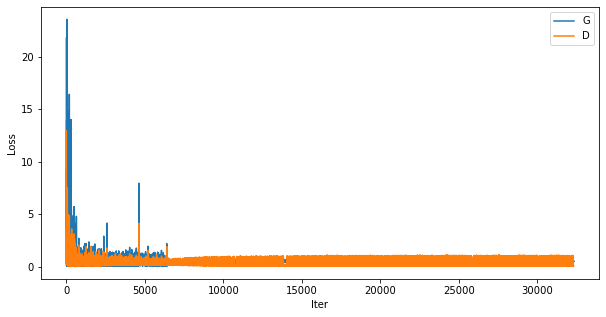

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

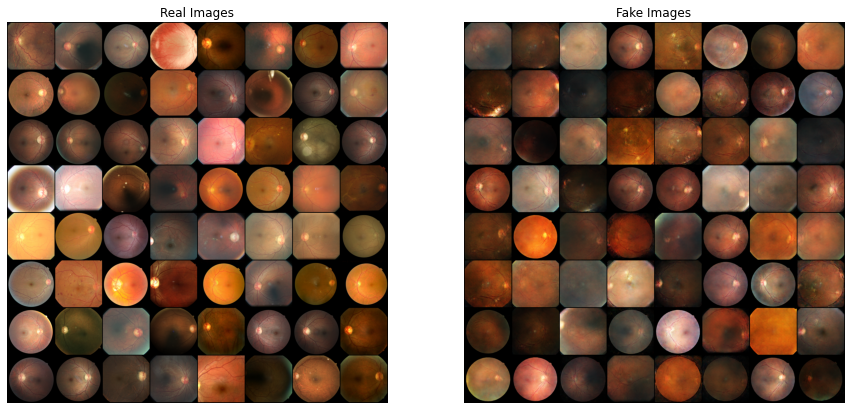

In [8]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()

In [9]:
#Save
state = {
    'net': net_D.state_dict(),
    'acc': 0,
    'epoch': num_epochs,
}
if not os.path.isdir('checkpoint/exp6'):
    os.mkdir('checkpoint/exp6')
torch.save(state, './checkpoint/exp6/ckpt3.pth')